# 句向量跑類神經網路

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq
import math
import pickle
import time

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

## 匯入資料

In [93]:
path_ = r'C:\Users\e2414\OneDrive\桌面\專題\AllData\training'  #資料從哪裡來
path_model = r'C:\Users\e2414\OneDrive\桌面\專題\AllData\training\clf_model' # 模型匯到哪裡去

In [ ]:
%%time
with open(path_+ r"/train.pkl", "rb") as f:
    train = pickle.load(f)
    
with open(path_+ r"/trainlabel.pkl", "rb") as f:
    trainlabel = pickle.load(f)
    
print(np.shape(train))
print(np.shape(trainlabel))    

### 定義 label

In [ ]:
label = list(range(1, 40+1))
print(label)

## try 部分資料
抽樣過的 12250 筆句向量

In [94]:
%%time
path_ = r'C:\Users\e2414\OneDrive\桌面\專題\AllData\training\emoji_sampling'  #資料從哪裡來

train = pd.read_excel(path_ + r'\3rand_emo400.xlsx')
#train = pd.read_csv(path_ + r'\emo400_pp2.csv')

train = train.drop("Unnamed: 0", axis = 1)
train = np.array(train)
label = list(range(1, 40+1))
trainlabel = np.repeat(label, 400)   

print(label)
print(len(trainlabel))
train.shape

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
16000
Wall time: 56.1 s


(16000, 300)

## 將資料切為 訓練集 與 測試集

In [95]:
X_train, X_test, y_train, y_test = train_test_split(train, trainlabel, 
                                                    test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12800, 300)
(3200, 300)
(12800,)
(3200,)


## 提供 3 類的機率

In [96]:
def acc3type(prob, clf_label, result = False):
    
    '''  
    "prob" : sklearn 套件 predict 出的 不同類別的 probabilty matrix (列:每筆資料，欄:不同的label)
    "clf_label" :  用於 與實際label比對抓出機率， ex: 做cv時，是拿 training set 做，所以是trainlabel；做predict時，是拿 testing set 做，所以是testlabel；
    "result" : 要不要印出每筆資料前3可能發生的機率，預設是不印 (做cv時因為只要看accuracy:不印 ； 做predict時想看機率:印)  
    '''
    
    
    p_acc = []
    hit = 0
    
    for l in range(0, len(prob)):

        # 第l筆資料的各種類別機率list
        rlist = prob[l].tolist() 

        # 最大3個機率的位置 (即第幾類)
        p3_loc = heapq.nlargest(3, range(len(rlist)), key= rlist.__getitem__)    # 這語法我找好久... r明明超簡單...

        # 最大的3類 & 對應的機率
        want = [(label[r], round(rlist[r], 3)) for r in p3_loc if rlist[r] != 0]   #給出 (label, p) 的 tuple 且 p = 0 的話我不要
        want.sort(key = lambda x: x[1], reverse= True)  #讓他按照 p 的大小排序
        
        if result:
            print("第", l, "筆資料，最可能發生的 3 種 (label, p): ", want)  # 從第 0 筆開始哦，之後可看看要不要+1 (怕混淆先沒加) 

            
        pa = [p for (i, p) in want if i == clf_label[l]]  # 挑出與實際label相同的機率。實際label有在model判斷的前三名才有機率，沒有的話給空的list
        p_acc = p_acc + pa
        
        if len(pa)!=0:
            hit = hit + 1
            

    acc = sum(p_acc)/len(prob) # 因為實際label可能沒被判成前3名，會給空字串，so要把他當作0算，去除以全部的資料數量，而不是 p_acc 的數量  
    hit_acc = hit/len(prob)
    
    
    if result:
        print("\n")
        print("選對的機率當作權重 の accuracy :" , round(acc, 3))
        print("3 個中一個就算對 の accuracy :" , round(hit_acc, 3))
        
        '''
        利用"acc"，「選對的機率當作權重 の accuracy」來調參數，因為它會影響表情符號出現的機率，也就是會影響推薦順序
        利用"hit_acc"，「3 個中一個就算對 の accuracy」來呈現，因為大家覺得3個有一個是想要的就很棒ㄌ
        '''
        
    
    return acc, hit_acc

### for training

In [142]:
%%time
lay1 = 512
lay2 = 256
lay3 = 64
lay4 = 32

# neural network
#alpha:L2
#
nn_model = MLPClassifier(solver='adam', alpha=2e-4, hidden_layer_sizes=(lay1, lay2, lay3, lay4), 
                max_iter= 100000, random_state=1, tol=1e-4, verbose=2)

# k-fold Cross Validation
kf = KFold(n_splits=k, random_state=1, shuffle=True) # random_state = set.seed()
prob = cross_val_predict(nn_model, X_train, y_train, cv= kf, n_jobs=-1, method = 'predict_proba')

acc_result = acc3type(prob, y_train, result = False)

print("選對的機率當作權重 の accuracy 為 {}".format(round(acc_result[0], 3)))
print("三個中一個就算對 の accuracy 為 {}".format(round(acc_result[1], 3)))

print("hidden layers 為 ({}, {}, {}, {}) ".format(lay1, lay2, lay3, lay4))
print("")

選對的機率當作權重 の accuracy 為 0.161
三個中一個就算對 の accuracy 為 0.288
hidden layers 為 (512, 256, 64, 32) 

Wall time: 4min 55s


-  (128, 64): 0.50491416  ，0.1853125  
    - 選對的機率當作權重 の accuracy 為 0.157，三個中一個就算對 の accuracy 為 0.285
- (128, 64, 16): 0.58517033  ，第一個就答對的機率: 0.185625  
    - 選對的機率當作權重 の accuracy 為 0.152，三個中一個就算對 の accuracy 為 0.278
- (128, 64, 32, 16): 0.61512334
- (512, 256, 64, 32): 0.36704449 ，第一個就答對的機率: 0.189375    
    - 選對的機率當作權重 の accuracy : 0.168，3 個中一個就算對 の accuracy : 0.296  ，loss降低acc沒有跟著增加
    - 選對的機率當作權重 の accuracy 為 0.161，三個中一個就算對 の accuracy 為 0.288

### for testing
the model has to be trained (with the fit method) before it can be used to predict  
會多跑一次，但沒辦法...

In [143]:
%%time
nn_model.fit(X_train, y_train)

Iteration 1, loss = 3.45768390
Iteration 2, loss = 3.16978603
Iteration 3, loss = 3.00660948
Iteration 4, loss = 2.87834275
Iteration 5, loss = 2.74486939
Iteration 6, loss = 2.62347893
Iteration 7, loss = 2.49527175
Iteration 8, loss = 2.34756469
Iteration 9, loss = 2.20411484
Iteration 10, loss = 2.05902901
Iteration 11, loss = 1.89677084
Iteration 12, loss = 1.74555982
Iteration 13, loss = 1.61862208
Iteration 14, loss = 1.48010997
Iteration 15, loss = 1.34114066
Iteration 16, loss = 1.25564404
Iteration 17, loss = 1.12861361
Iteration 18, loss = 1.04443657
Iteration 19, loss = 0.96013213
Iteration 20, loss = 0.89817101
Iteration 21, loss = 0.83375636
Iteration 22, loss = 0.79302867
Iteration 23, loss = 0.73425032
Iteration 24, loss = 0.68784497
Iteration 25, loss = 0.67438241
Iteration 26, loss = 0.65174291
Iteration 27, loss = 0.62143747
Iteration 28, loss = 0.59270898
Iteration 29, loss = 0.57923095
Iteration 30, loss = 0.56451644
Iteration 31, loss = 0.55245339
Iteration 32, los

MLPClassifier(alpha=0.0002, hidden_layer_sizes=(512, 256, 64, 32),
              max_iter=100000, random_state=1, verbose=2)

(300, 512)
(512, 256)
(256, 64)


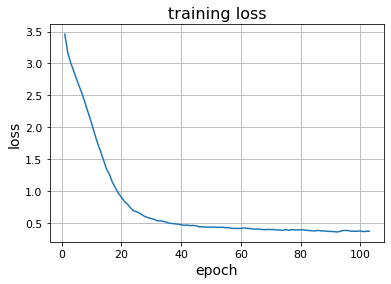

In [144]:
print(np.shape(nn_model.coefs_[0])) #隱藏層的係數
print(np.shape(nn_model.coefs_[1])) #隱藏層的係數
print(np.shape(nn_model.coefs_[2])) #隱藏層的係數
#print(np.shape(nn_model.coefs_[3])) #隱藏層的係數
#print(model.coefs_)

loss_trend = nn_model.loss_curve_

plt.plot(range(1, len(loss_trend) + 1) , loss_trend)
plt.title("training loss", fontsize= 16)
plt.xlabel('epoch', fontsize= 14)
plt.ylabel('loss', fontsize= 14)
plt.yticks(fontsize= 11)
plt.xticks(fontsize= 11)

plt.grid()

In [145]:
# 所有資料被分到每個類別的機率 (matrix)
prob = nn_model.predict_proba(X_test)  
np.shape(prob)  #有250筆 共5個類別的資料

(3200, 40)

In [146]:
acc3type(prob,  y_test, result = True)

第 0 筆資料，最可能發生的 3 種 (label, p):  [(25, 0.996), (39, 0.004), (8, 0.0)]
第 1 筆資料，最可能發生的 3 種 (label, p):  [(12, 0.338), (16, 0.237), (35, 0.227)]
第 2 筆資料，最可能發生的 3 種 (label, p):  [(31, 0.544), (22, 0.183), (10, 0.057)]
第 3 筆資料，最可能發生的 3 種 (label, p):  [(16, 0.955), (25, 0.018), (13, 0.009)]
第 4 筆資料，最可能發生的 3 種 (label, p):  [(27, 0.529), (23, 0.372), (24, 0.079)]
第 5 筆資料，最可能發生的 3 種 (label, p):  [(18, 0.858), (22, 0.097), (39, 0.021)]
第 6 筆資料，最可能發生的 3 種 (label, p):  [(22, 0.654), (18, 0.15), (2, 0.141)]
第 7 筆資料，最可能發生的 3 種 (label, p):  [(38, 0.933), (26, 0.034), (22, 0.012)]
第 8 筆資料，最可能發生的 3 種 (label, p):  [(37, 0.97), (10, 0.022), (33, 0.008)]
第 9 筆資料，最可能發生的 3 種 (label, p):  [(24, 0.513), (20, 0.339), (28, 0.128)]
第 10 筆資料，最可能發生的 3 種 (label, p):  [(29, 0.829), (17, 0.164), (25, 0.007)]
第 11 筆資料，最可能發生的 3 種 (label, p):  [(37, 0.329), (31, 0.243), (40, 0.202)]
第 12 筆資料，最可能發生的 3 種 (label, p):  [(26, 0.396), (2, 0.374), (25, 0.224)]
第 13 筆資料，最可能發生的 3 種 (label, p):  [(34, 0.813), (39, 0.129), (13, 0.0

第 388 筆資料，最可能發生的 3 種 (label, p):  [(27, 0.935), (16, 0.042), (12, 0.008)]
第 389 筆資料，最可能發生的 3 種 (label, p):  [(24, 0.591), (35, 0.178), (39, 0.156)]
第 390 筆資料，最可能發生的 3 種 (label, p):  [(24, 0.973), (22, 0.021), (2, 0.003)]
第 391 筆資料，最可能發生的 3 種 (label, p):  [(32, 0.988), (29, 0.005), (26, 0.004)]
第 392 筆資料，最可能發生的 3 種 (label, p):  [(18, 0.296), (27, 0.205), (29, 0.126)]
第 393 筆資料，最可能發生的 3 種 (label, p):  [(7, 0.639), (24, 0.155), (10, 0.124)]
第 394 筆資料，最可能發生的 3 種 (label, p):  [(16, 0.999), (12, 0.001), (4, 0.0)]
第 395 筆資料，最可能發生的 3 種 (label, p):  [(23, 0.905), (3, 0.054), (31, 0.031)]
第 396 筆資料，最可能發生的 3 種 (label, p):  [(2, 0.196), (26, 0.12), (38, 0.088)]
第 397 筆資料，最可能發生的 3 種 (label, p):  [(36, 0.545), (7, 0.21), (25, 0.085)]
第 398 筆資料，最可能發生的 3 種 (label, p):  [(29, 0.865), (33, 0.058), (23, 0.036)]
第 399 筆資料，最可能發生的 3 種 (label, p):  [(20, 0.438), (29, 0.396), (33, 0.081)]
第 400 筆資料，最可能發生的 3 種 (label, p):  [(13, 0.993), (5, 0.003), (18, 0.001)]
第 401 筆資料，最可能發生的 3 種 (label, p):  [(6, 0.699), (3

第 760 筆資料，最可能發生的 3 種 (label, p):  [(14, 0.675), (23, 0.219), (19, 0.081)]
第 761 筆資料，最可能發生的 3 種 (label, p):  [(29, 0.584), (35, 0.304), (39, 0.056)]
第 762 筆資料，最可能發生的 3 種 (label, p):  [(20, 0.548), (26, 0.309), (24, 0.132)]
第 763 筆資料，最可能發生的 3 種 (label, p):  [(28, 0.8), (40, 0.167), (12, 0.013)]
第 764 筆資料，最可能發生的 3 種 (label, p):  [(33, 1.0), (17, 0.0), (35, 0.0)]
第 765 筆資料，最可能發生的 3 種 (label, p):  [(8, 0.17), (4, 0.157), (13, 0.149)]
第 766 筆資料，最可能發生的 3 種 (label, p):  [(35, 0.952), (17, 0.025), (40, 0.015)]
第 767 筆資料，最可能發生的 3 種 (label, p):  [(19, 0.749), (40, 0.112), (35, 0.045)]
第 768 筆資料，最可能發生的 3 種 (label, p):  [(30, 0.5), (22, 0.258), (29, 0.117)]
第 769 筆資料，最可能發生的 3 種 (label, p):  [(34, 0.903), (23, 0.04), (17, 0.019)]
第 770 筆資料，最可能發生的 3 種 (label, p):  [(30, 0.59), (6, 0.248), (15, 0.033)]
第 771 筆資料，最可能發生的 3 種 (label, p):  [(38, 1.0), (29, 0.0), (18, 0.0)]
第 772 筆資料，最可能發生的 3 種 (label, p):  [(5, 0.412), (32, 0.358), (38, 0.15)]
第 773 筆資料，最可能發生的 3 種 (label, p):  [(36, 0.996), (23, 0.003), (

第 1189 筆資料，最可能發生的 3 種 (label, p):  [(38, 0.978), (13, 0.012), (32, 0.003)]
第 1190 筆資料，最可能發生的 3 種 (label, p):  [(7, 0.925), (26, 0.03), (9, 0.017)]
第 1191 筆資料，最可能發生的 3 種 (label, p):  [(4, 0.999), (1, 0.0), (19, 0.0)]
第 1192 筆資料，最可能發生的 3 種 (label, p):  [(5, 0.69), (13, 0.309), (11, 0.0)]
第 1193 筆資料，最可能發生的 3 種 (label, p):  [(26, 0.259), (29, 0.231), (38, 0.149)]
第 1194 筆資料，最可能發生的 3 種 (label, p):  [(35, 0.382), (33, 0.287), (19, 0.221)]
第 1195 筆資料，最可能發生的 3 種 (label, p):  [(13, 0.837), (7, 0.127), (34, 0.018)]
第 1196 筆資料，最可能發生的 3 種 (label, p):  [(35, 0.92), (33, 0.04), (27, 0.031)]
第 1197 筆資料，最可能發生的 3 種 (label, p):  [(33, 0.697), (39, 0.212), (34, 0.051)]
第 1198 筆資料，最可能發生的 3 種 (label, p):  [(17, 0.969), (23, 0.012), (14, 0.012)]
第 1199 筆資料，最可能發生的 3 種 (label, p):  [(17, 0.4), (25, 0.189), (29, 0.162)]
第 1200 筆資料，最可能發生的 3 種 (label, p):  [(38, 0.793), (18, 0.102), (22, 0.09)]
第 1201 筆資料，最可能發生的 3 種 (label, p):  [(9, 0.9), (37, 0.097), (13, 0.002)]
第 1202 筆資料，最可能發生的 3 種 (label, p):  [(21, 0.992)

第 1622 筆資料，最可能發生的 3 種 (label, p):  [(22, 0.987), (16, 0.006), (17, 0.005)]
第 1623 筆資料，最可能發生的 3 種 (label, p):  [(13, 1.0), (11, 0.0), (7, 0.0)]
第 1624 筆資料，最可能發生的 3 種 (label, p):  [(36, 0.485), (20, 0.38), (40, 0.07)]
第 1625 筆資料，最可能發生的 3 種 (label, p):  [(37, 0.868), (9, 0.071), (10, 0.028)]
第 1626 筆資料，最可能發生的 3 種 (label, p):  [(30, 0.302), (7, 0.251), (11, 0.152)]
第 1627 筆資料，最可能發生的 3 種 (label, p):  [(11, 0.164), (17, 0.16), (10, 0.123)]
第 1628 筆資料，最可能發生的 3 種 (label, p):  [(39, 0.415), (2, 0.191), (12, 0.124)]
第 1629 筆資料，最可能發生的 3 種 (label, p):  [(30, 0.488), (6, 0.43), (7, 0.014)]
第 1630 筆資料，最可能發生的 3 種 (label, p):  [(8, 0.768), (7, 0.117), (16, 0.026)]
第 1631 筆資料，最可能發生的 3 種 (label, p):  [(14, 0.998), (8, 0.001), (20, 0.0)]
第 1632 筆資料，最可能發生的 3 種 (label, p):  [(36, 1.0), (17, 0.0), (2, 0.0)]
第 1633 筆資料，最可能發生的 3 種 (label, p):  [(24, 0.612), (3, 0.167), (25, 0.07)]
第 1634 筆資料，最可能發生的 3 種 (label, p):  [(28, 0.916), (20, 0.083), (37, 0.001)]
第 1635 筆資料，最可能發生的 3 種 (label, p):  [(29, 0.324), (7, 0.

第 2047 筆資料，最可能發生的 3 種 (label, p):  [(5, 0.478), (22, 0.27), (23, 0.174)]
第 2048 筆資料，最可能發生的 3 種 (label, p):  [(17, 0.981), (16, 0.017), (18, 0.001)]
第 2049 筆資料，最可能發生的 3 種 (label, p):  [(5, 0.89), (22, 0.025), (13, 0.021)]
第 2050 筆資料，最可能發生的 3 種 (label, p):  [(13, 0.45), (35, 0.262), (32, 0.12)]
第 2051 筆資料，最可能發生的 3 種 (label, p):  [(3, 0.622), (2, 0.296), (19, 0.065)]
第 2052 筆資料，最可能發生的 3 種 (label, p):  [(28, 0.633), (21, 0.2), (11, 0.098)]
第 2053 筆資料，最可能發生的 3 種 (label, p):  [(13, 0.439), (11, 0.071), (7, 0.05)]
第 2054 筆資料，最可能發生的 3 種 (label, p):  [(4, 0.801), (27, 0.123), (12, 0.049)]
第 2055 筆資料，最可能發生的 3 種 (label, p):  [(24, 0.693), (1, 0.276), (11, 0.011)]
第 2056 筆資料，最可能發生的 3 種 (label, p):  [(28, 0.511), (22, 0.206), (38, 0.128)]
第 2057 筆資料，最可能發生的 3 種 (label, p):  [(27, 0.398), (24, 0.219), (3, 0.083)]
第 2058 筆資料，最可能發生的 3 種 (label, p):  [(28, 0.516), (23, 0.255), (21, 0.131)]
第 2059 筆資料，最可能發生的 3 種 (label, p):  [(14, 1.0), (15, 0.0), (11, 0.0)]
第 2060 筆資料，最可能發生的 3 種 (label, p):  [(28, 0.775

第 2480 筆資料，最可能發生的 3 種 (label, p):  [(38, 0.83), (2, 0.15), (36, 0.011)]
第 2481 筆資料，最可能發生的 3 種 (label, p):  [(31, 0.534), (19, 0.371), (14, 0.057)]
第 2482 筆資料，最可能發生的 3 種 (label, p):  [(40, 0.822), (23, 0.064), (22, 0.042)]
第 2483 筆資料，最可能發生的 3 種 (label, p):  [(25, 0.766), (39, 0.224), (29, 0.006)]
第 2484 筆資料，最可能發生的 3 種 (label, p):  [(22, 0.983), (2, 0.009), (17, 0.005)]
第 2485 筆資料，最可能發生的 3 種 (label, p):  [(29, 0.357), (12, 0.224), (40, 0.161)]
第 2486 筆資料，最可能發生的 3 種 (label, p):  [(38, 0.997), (16, 0.001), (18, 0.0)]
第 2487 筆資料，最可能發生的 3 種 (label, p):  [(6, 0.699), (30, 0.077), (7, 0.036)]
第 2488 筆資料，最可能發生的 3 種 (label, p):  [(2, 0.984), (18, 0.008), (36, 0.003)]
第 2489 筆資料，最可能發生的 3 種 (label, p):  [(27, 0.663), (29, 0.288), (32, 0.041)]
第 2490 筆資料，最可能發生的 3 種 (label, p):  [(14, 0.879), (15, 0.062), (8, 0.036)]
第 2491 筆資料，最可能發生的 3 種 (label, p):  [(11, 0.857), (1, 0.047), (4, 0.037)]
第 2492 筆資料，最可能發生的 3 種 (label, p):  [(3, 0.666), (33, 0.159), (27, 0.152)]
第 2493 筆資料，最可能發生的 3 種 (label, p):  [(3

第 2901 筆資料，最可能發生的 3 種 (label, p):  [(25, 0.878), (40, 0.095), (29, 0.02)]
第 2902 筆資料，最可能發生的 3 種 (label, p):  [(24, 0.227), (4, 0.225), (23, 0.19)]
第 2903 筆資料，最可能發生的 3 種 (label, p):  [(13, 0.06), (38, 0.057), (7, 0.057)]
第 2904 筆資料，最可能發生的 3 種 (label, p):  [(26, 0.999), (20, 0.001), (38, 0.0)]
第 2905 筆資料，最可能發生的 3 種 (label, p):  [(17, 0.942), (40, 0.021), (19, 0.016)]
第 2906 筆資料，最可能發生的 3 種 (label, p):  [(8, 0.769), (14, 0.192), (13, 0.03)]
第 2907 筆資料，最可能發生的 3 種 (label, p):  [(7, 0.063), (15, 0.057), (13, 0.056)]
第 2908 筆資料，最可能發生的 3 種 (label, p):  [(26, 0.732), (1, 0.209), (7, 0.024)]
第 2909 筆資料，最可能發生的 3 種 (label, p):  [(24, 0.978), (22, 0.013), (3, 0.004)]
第 2910 筆資料，最可能發生的 3 種 (label, p):  [(12, 0.888), (3, 0.078), (40, 0.033)]
第 2911 筆資料，最可能發生的 3 種 (label, p):  [(33, 0.613), (17, 0.332), (36, 0.046)]
第 2912 筆資料，最可能發生的 3 種 (label, p):  [(5, 0.197), (11, 0.12), (4, 0.119)]
第 2913 筆資料，最可能發生的 3 種 (label, p):  [(22, 0.528), (2, 0.354), (26, 0.099)]
第 2914 筆資料，最可能發生的 3 種 (label, p):  [(11, 0.

(0.1677943749999997, 0.2959375)

In [149]:
# 第一個就答對的機率
nn_model.score(X_test, y_test)

0.189375